In [1]:
# データセットの読み込み
from datasets import load_dataset
data_files = {}
for name in ["train", "val", "test"]:
    data_files[name] = f"data/qmsum/{name}.jsonl" 
data = load_dataset("json", data_files=data_files, cache_dir="data/preloaded")
data["train"][1]["query"]

/home/hattori-k/.conda/envs/qa/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using custom data configuration default-8a26b48d0a74ff55
Reusing dataset json (data/preloaded/json/default-8a26b48d0a74ff55/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)
100%|██████████| 3/3 [00:00<00:00, 716.49it/s]


'How Did Project Manager and User Interface introduce the prototype of the remote control?'

In [6]:
# モデルの読み込み
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
model_dir = "facebook/bart-large"
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

Token indices sequence length is longer than the specified maximum sequence length for this model (5747 > 1024). Running this sequence through the model will result in indexing errors


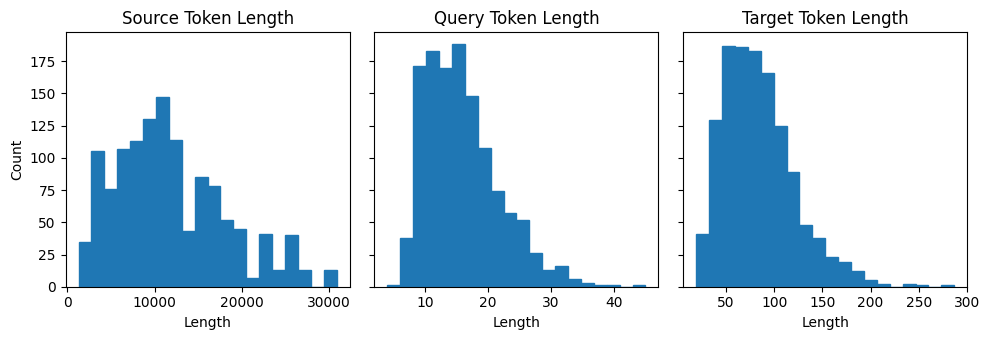

In [19]:
# データセットの確認
import matplotlib.pyplot as plt

s_len = [len(tokenizer.encode(s)) for s in data["train"]["source"]]
q_len = [len(tokenizer.encode(s)) for s in data["train"]["query"]]
t_len = [len(tokenizer.encode(s)) for s in data["train"]["target"]]

fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True)
axes[0].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Source Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(q_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Query Token Length")
axes[1].set_xlabel("Length")
axes[2].hist(t_len, bins=20, color="C0", edgecolor="C0")
axes[2].set_title("Target Token Length")
axes[2].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [17]:
# データのtokenization
def tokenize(examples):
    inputs = [f"<s>{query}</s>{source}</s>" for query, source in zip(examples["query"], examples["source"])]
    model_inputs = tokenizer(
        inputs,
        max_length=tokenizer.model_max_length,
        add_special_tokens=False,
        truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["target"], 
            max_length=tokenizer.model_max_length,
            add_special_tokens=False,
            truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_qmsum = data.map(tokenize, batched=True)

100%|██████████| 1/1 [00:01<00:00,  1.12s/ba]


In [ ]:
# モデルの訓練・ファインチューニング
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="bart-large-qmsum",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    fp16=True,
    push_to_hub=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_qmsum["train"],
    eval_dataset=tokenized_qmsum["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

In [25]:
from datasets import load_metric
rouge_metric = load_metric("rouge")
